In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


In [3]:
df = pd.read_csv(r"C:\Users\timil\Downloads\Isolation_test.csv")
df

,Item Description,Order Fiscal Week,Quantity Ordered,Order Date
0,DA192 PWA,202102,1,2021-01-08 06:26:00
1,DA192 PWA,202103,1,2021-01-12 16:48:00
2,DA192 PWA,202104,1,2021-01-20 12:57:00
3,DA192 PWA,202104,1,2021-01-22 19:46:00
4,DA192 PWA,202105,1,2021-01-28 06:26:00
...,...,...,...,...
452,DA192 PWA,202252,1,2022-12-28 08:45:00
453,DA192 PWA,202252,1,2022-12-29 01:15:00
454,DA192 PWA,202252,1,2022-12-29 03:04:00
455,DA192 PWA,202252,1,2022-12-30 08:36:00


In [4]:
df.isna().sum()

Item Description     0
Order Fiscal Week    0
Quantity Ordered     0
Order Date           0
dtype: int64

In [5]:
df.dtypes

Item Description     object
Order Fiscal Week     int64
Quantity Ordered      int64
Order Date           object
dtype: object

In [6]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [7]:
df.dtypes

Item Description             object
Order Fiscal Week             int64
Quantity Ordered              int64
Order Date           datetime64[ns]
dtype: object

In [8]:
df['Order Fiscal Week'] = pd.to_datetime(df['Order Fiscal Week'])

In [9]:
df

,Item Description,Order Fiscal Week,Quantity Ordered,Order Date
0,DA192 PWA,1970-01-01 00:00:00.000202102,1,2021-01-08 06:26:00
1,DA192 PWA,1970-01-01 00:00:00.000202103,1,2021-01-12 16:48:00
2,DA192 PWA,1970-01-01 00:00:00.000202104,1,2021-01-20 12:57:00
3,DA192 PWA,1970-01-01 00:00:00.000202104,1,2021-01-22 19:46:00
4,DA192 PWA,1970-01-01 00:00:00.000202105,1,2021-01-28 06:26:00
...,...,...,...,...
452,DA192 PWA,1970-01-01 00:00:00.000202252,1,2022-12-28 08:45:00
453,DA192 PWA,1970-01-01 00:00:00.000202252,1,2022-12-29 01:15:00
454,DA192 PWA,1970-01-01 00:00:00.000202252,1,2022-12-29 03:04:00
455,DA192 PWA,1970-01-01 00:00:00.000202252,1,2022-12-30 08:36:00


In [10]:
weekly = (
    df.groupby(["Item Description", pd.Grouper(key="Order Date", freq="W")])["Quantity Ordered"]
    .sum()
    .reset_index()
)

In [11]:
weekly

,Item Description,Order Date,Quantity Ordered
0,DA192 PWA,2021-01-10,1
1,DA192 PWA,2021-01-17,1
2,DA192 PWA,2021-01-24,2
3,DA192 PWA,2021-01-31,2
4,DA192 PWA,2021-02-07,2
...,...,...,...
86,DA192 PWA,2022-12-04,8
87,DA192 PWA,2022-12-11,11
88,DA192 PWA,2022-12-18,12
89,DA192 PWA,2022-12-25,14


In [12]:
results = []
for item, subdf in weekly.groupby("Item Description"):
    X = subdf[["Quantity Ordered"]].values

    # Initialize Isolation Forest
    iso = IsolationForest(
        contamination=0.05,
        random_state=42
    )
    iso.fit(X)

    # Predict anomalies
    subdf["Anomaly_Score"] = iso.decision_function(X)
    subdf["Anomaly"] = iso.predict(X)
    

    results.append(subdf)

anomaly_df = pd.concat(results).reset_index(drop=True)


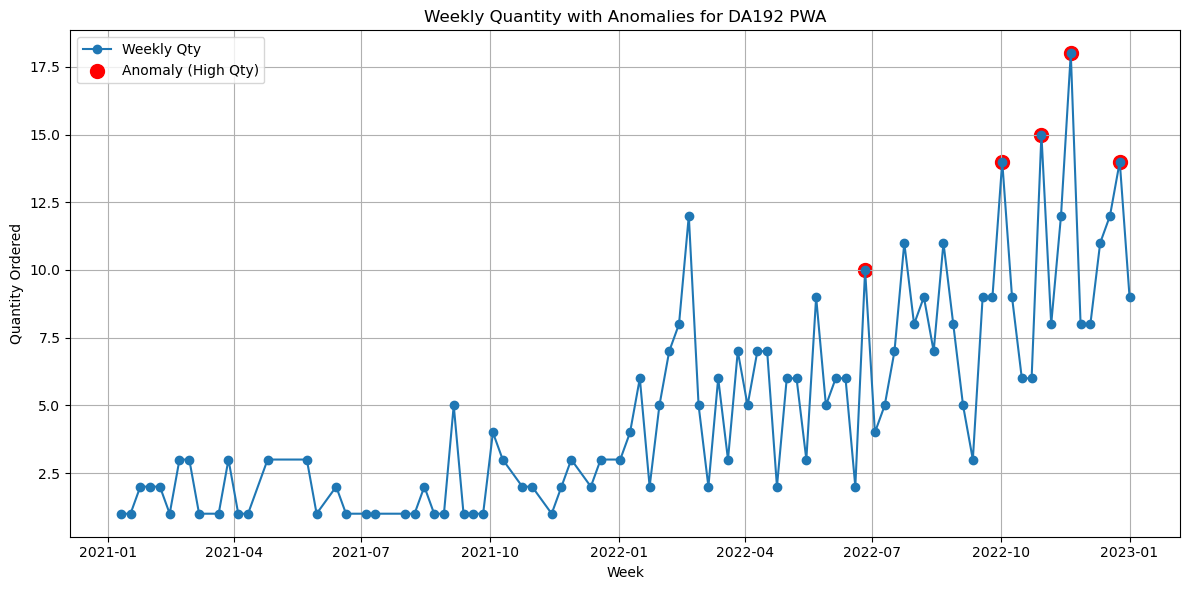

In [13]:
item_to_plot = anomaly_df["Item Description"].unique()[0]  # change as needed
subset = anomaly_df[anomaly_df["Item Description"] == item_to_plot]

plt.figure(figsize=(12, 6))
plt.plot(subset["Order Date"], subset["Quantity Ordered"], label="Weekly Qty", marker="o")
plt.scatter(
    subset.loc[subset["Anomaly"] == -1, "Order Date"],
    subset.loc[subset["Anomaly"] == -1, "Quantity Ordered"],
    color="red",
    label="Anomaly (High Qty)",
    s=100,
)
plt.title(f"Weekly Quantity with Anomalies for {item_to_plot}")
plt.xlabel("Week")
plt.ylabel("Quantity Ordered")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
print(anomaly_df[anomaly_df["Anomaly"] == -1].sort_values(by=["Item Description", "Order Date"]))


   Item Description Order Date  Quantity Ordered  Anomaly_Score  Anomaly
63        DA192 PWA 2022-06-26                10      -0.015839       -1
77        DA192 PWA 2022-10-02                14      -0.013600       -1
81        DA192 PWA 2022-10-30                15      -0.085567       -1
84        DA192 PWA 2022-11-20                18      -0.175097       -1
89        DA192 PWA 2022-12-25                14      -0.013600       -1
